In [59]:
# Packages
import numpy as np
import pandas as pd
#import scipy
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import poisson 
#import pystan

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sb.set()

# Settings for Stan
#Niters = 1000
#Nchains = 5

In [2]:
PK = pd.read_csv('../input/PoliceKillingsUS.csv', encoding='latin1')

In [3]:
PK.sample(n=10)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
1263,1443,Luis Gongora,07/04/16,shot,knife,45.0,M,H,San Francisco,CA,False,other,Not fleeing,False
1881,2099,Josh Dunne,02/12/16,shot,undetermined,36.0,M,W,Las Cruces,NM,True,undetermined,Not fleeing,False
1653,1860,Donny Max Daugherty,03/09/16,shot,gun,36.0,M,W,Metropolis,IL,False,undetermined,Other,False
2148,2396,Isidro Bazan Jr,02/03/17,shot,baseball bat,34.0,M,H,San Marcos,CA,False,other,Not fleeing,False
1719,1930,Najier Salaam,30/09/16,shot,undetermined,18.0,M,B,Newark,NJ,False,undetermined,Not fleeing,False
1107,1266,Calvin Smith,13/02/16,shot,gun,22.0,M,B,Baton Rouge,LA,True,attack,Car,True
1165,1342,Brandon Stanley,04/03/16,shot,unarmed,30.0,M,W,East Berstadt,KY,False,undetermined,Not fleeing,False
1645,1847,Joshua Quintero,01/09/16,shot,gun,23.0,M,H,Florence,CA,False,other,Foot,False
194,210,Troy Ray Boyd,15/03/15,shot,machete,27.0,M,W,Ruth,MS,False,other,Not fleeing,False
632,763,Thaddeus Faison,22/08/15,shot and Tasered,gun,39.0,M,B,Troy,NY,False,attack,Foot,False


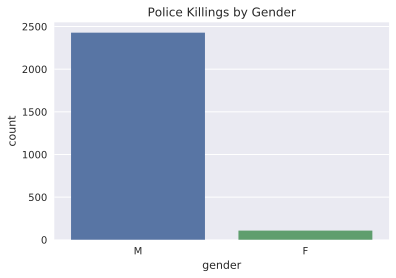

In [4]:
# Plot police killings by gender
sb.countplot(x = "gender", 
             data = PK,
             order = PK.gender.value_counts().index)
plt.title('Police Killings by Gender')
plt.show()

According to the [US census](https://www.census.gov), the population of the United States is 50.8% female and 49.2% male.  How does this distribution match up to the distribution of police killings.  That is - if police were killing people completely at random, what would the killings distribution look like?

First let's define a function which will return a dataframe with the actual percentages and also the population percentages for any per-group count.

In [5]:
def ActualVsPopulation(df, pop, group):
    """Get dataframe with actual per-group percentage vs population group percentage"""
    d = {group: [], 'type': [], 'percent': []}
    tot_pop = float(sum(pop.values()))
    for g in df[group].dropna().unique(): #for each group

        # Actual percentages
        d[group].append(g)
        d['type'].append('Actual')
        d['percent'].append(100*df[df[group]==g].id.count()/df.id.count())

        # Percentages if statistic followed population distribution
        d[group].append(g)
        d['type'].append('Population') #based on population percentage
        d['percent'].append(100*pop[g]/tot_pop)
        
    return pd.DataFrame(data=d)

Now we can see the actual killings distribution versus the population distribution:

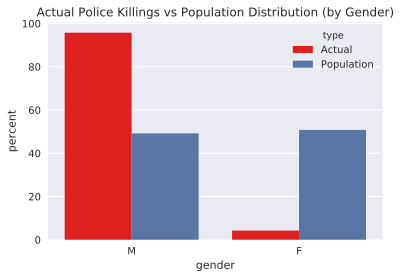

In [13]:
# Plot percent police killings by gender vs population percentages
pop_g = {'M': 49.2, 'F': 50.8} #percent population by gender https://www.census.gov/quickfacts/fact/table/US
df = ActualVsPopulation(PK, pop_g, 'gender')
sb.barplot(x="gender", y="percent", hue="type", data=df, palette=["r", "C0"])
plt.title('Actual Police Killings vs Population Distribution (by Gender)')
plt.show()

Next we'll plot the number of police killings by race.

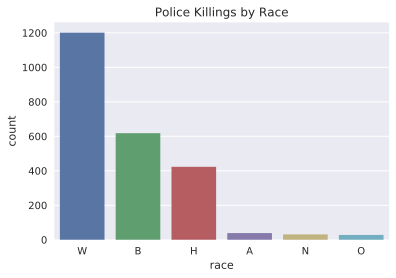

In [7]:
# Plot police killings by race
sb.countplot(x="race", 
             data=PK,
             order = PK.race.value_counts().index)
plt.title('Police Killings by Race')
plt.show()

How does this match up to the population distribution?

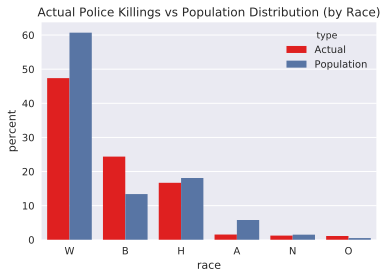

In [12]:
# Plot percent police killings by race vs population percentages
pop_r = {'W': 60.7, # white - % population by race https://www.census.gov/quickfacts/fact/table/US
         'B': 13.4, # black or african american
         'H': 18.1, # hispanic or latino
         'A': 5.8,  # asian
         'N': 1.5,  # american indian, alaska native, naitive hawaiian, and other pacific islander
         'O': 0.5}  # other
df = ActualVsPopulation(PK, pop_r, 'race')
sb.barplot(x="race", y="percent", hue="type", data=df,
           order = PK.race.value_counts().index, palette=["r", "C0"])
plt.title('Actual Police Killings vs Population Distribution (by Race)')
plt.show()

As you can see above, Black and Other are the only two racial categories with *more* police killings than would be expected if police killings were random.  And that effect isn't small - there are nearly *twice* as many police killings of black individuals than would be expected if these killings were random.  

Later we'll determine which states show more racially-biased police killings, but first let's plot the number of police killings by state:

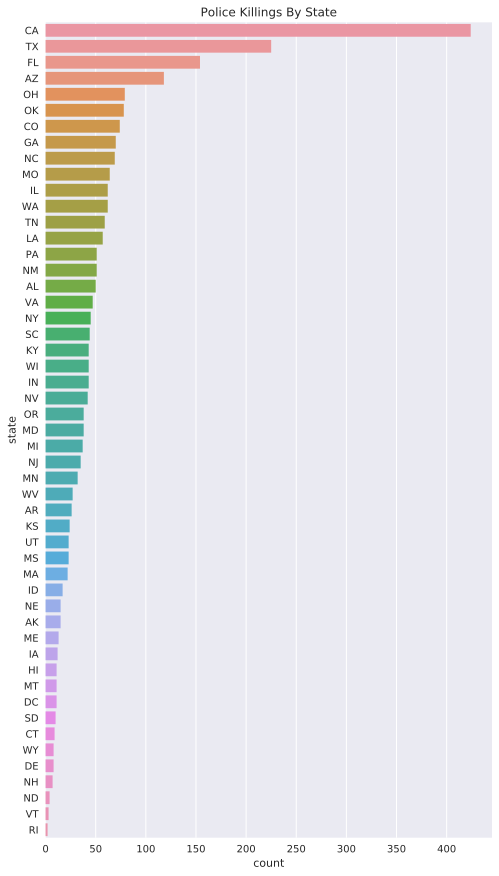

In [9]:
plt.figure(figsize=(8, 15))
sb.countplot(y="state", 
             data=PK,
             order=PK.state.value_counts().index)
plt.title('Police Killings By State')
plt.show()

And how does this match up to the population distribution of the states?

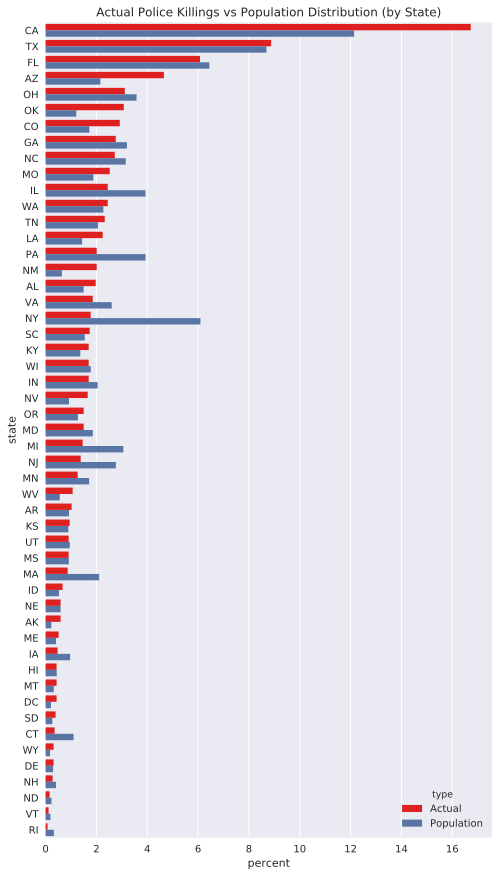

In [14]:
# Population for each state https://www.census.gov/data/datasets/2017/demo/popest/state-total.html
pop_s ={'AL': 4874747,
        'AK': 739795,
        'AZ': 7016270,
        'AR': 3004279,
        'CA': 39536653,
        'CO': 5607154,
        'CT': 3588184,
        'DE': 961939,
        'DC': 693972,
        'FL': 20984400,
        'GA': 10429379,
        'HI': 1427538,
        'ID': 1716943,
        'IL': 12802023,
        'IN': 6666818,
        'IA': 3145711,
        'KS': 2913123,
        'KY': 4454189,
        'LA': 4684333,
        'ME': 1335907,
        'MD': 6052177,
        'MA': 6859819,
        'MI': 9962311,
        'MN': 5576606,
        'MS': 2984100,
        'MO': 6113532,
        'MT': 1050493,
        'NE': 1920076,
        'NV': 2998039,
        'NH': 1342795,
        'NJ': 9005644,
        'NM': 2088070,
        'NY': 19849399,
        'NC': 10273419,
        'ND': 755393,
        'OH': 11658609,
        'OK': 3930864,
        'OR': 4142776,
        'PA': 12805537,
        'RI': 1059639,
        'SC': 5024369,
        'SD': 869666,
        'TN': 6715984,
        'TX': 28304596,
        'UT': 3101833,
        'VT': 623657,
        'VA': 8470020,
        'WA': 7405743,
        'WV': 1815857,
        'WI': 5795483,
        'WY': 579315}

# Plot percent police killings by state vs population percentages
df = ActualVsPopulation(PK, pop_s, 'state')
plt.figure(figsize=(8, 15))
sb.barplot(y="state", x="percent", hue="type", data=df,
           order = PK.state.value_counts().index, palette=["r", "C0"])
plt.title('Actual Police Killings vs Population Distribution (by State)')
plt.show()

Instead of plotting both the actual killings against the population distributions, we can compute a single number - a score which tells us how likely it is to see a number of killings (for a state or race) if killings were random, given the population distribution.  We'll use a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) to model the likelihood of observing the number of killings given the number of people in a certain group (state or race).  

A Poisson distribution models the likelihood of observing some number of events ($k$ events) within a set time window, given the constant (or expected) rate for which they are thought to occur ($\lambda$ events per time window).  We want to know the likelihood of the number of police killings of people from a given state or of a given race, so we'll set the $\lambda$ parameter to be the number of individuals in a certain population (race or state) which we would expect to be killed by police given the national average, and find the probability at $k=$ the number of people killed by police in that population.   If police killings don't depend on state or race, then the number of people killed by police in that population ($k$) should be proportional to the population ($\lambda$).  The further $k$ is from $\lambda$, the less likely it is that police killlings are biased in that population.

But we don't just want to find the *likelihood* that police killings are biased in different populations, we also want to know the *direction* in which they are biased.  That is, are there more or less police killings of people in a certian population than would be expected in that population if killings were random?  Therefore, we'll use the cumulative probability of the Poisson distribution, which will tell us the likelihood of observing a given number of killings *or less*.  That way, if the value of the cumulative poisson distribution is closer to 0, that means there were less killings of a certain population than would be expected if killings were random.  If the value is closer to 1, there were more killings than would be expected if killings were random.  And if the value is around 0.5, police shootings of people in that population were relatively unbiased.

The cumulative probability of the Poisson distribution can be computed by:

$$
p(X \leq k) = e^{-\lambda} \sum_{i=0}^{\left \lfloor{k}\right \rfloor} \frac{\lambda^i}{i !}
$$

where again $k$ is the number of observed killings and $\lambda$ is the expected number of killings if killings were random (given the population distribution).

Let's plot that metric for each state, to see which states have less police killings than the national average ($p(X \leq k) < 0.5$) and which states have more police killings than the national average ($p(X \leq k) > 0.5$).  I've plotted the bars such that they start at 0.5 to make this distinction more clear.

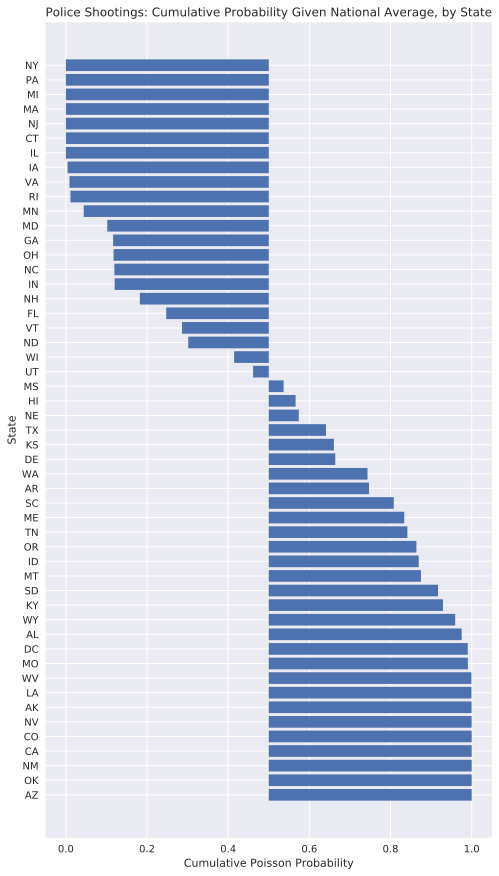

In [84]:
# Compute the cumulative Poisson distribution value for each state
natl_rate = PK.shape[0]/sum(pop_s.values()) #national average rate of police shootings per person
cum_poisson_vals = [] #to store cumulative poisson values
for state in pop_s.keys():
    lam = natl_rate*pop_s[state] #num shootings for this state if rate matched national avg (lambda)
    k = PK[PK.state==state].shape[0] #actual number of shootings in this state
    cum_poisson_vals.append(poisson.cdf(k, lam))

# Plot cumulative Poisson distribution values
plt.figure(figsize=(8, 15))
EK = pd.DataFrame(data={"state": list(pop_s.keys()), 
                        "cum_poisson": cum_poisson_vals})
EK.sort_values('cum_poisson', inplace=True)
y = np.arange(len(EK.state))
plt.barh(y, EK.cum_poisson-0.5, left=0.5)
ax = plt.gca()
ax.set_yticks(y)
ax.set_yticklabels(EK.state)
ax.invert_yaxis()
plt.title('Police Shootings: Cumulative Probability Given National Average, by State')
plt.ylabel('State')
plt.xlabel('Cumulative Poisson Probability')
plt.show()

So, Arizona has the highest frequency of police shootings given its population, while New York has the least.

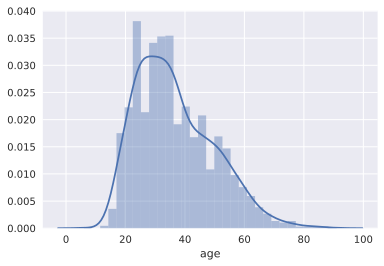

In [16]:
sb.distplot(PK.age[~np.isnan(PK.age)])
plt.show()

## TODO: 
- Age (dist above)
- Time of year
- Time of day
- Weather?
- Correlation w/ metrics in those census datasets?